# Step 1: Notebook Setup

The cell below contains a number of helper functions used throughout this walkthrough. They are mainly wrappers around existing `matplotlib` functionality and are provided for the sake of simplicity in the steps to come.

Take a moment to read the descriptions for each method so you understand what they can be used for. You will use these "helper methods" as you work through this notebook below.

If you are familiar with `matplotlib`, feel free to alter the functions as you please.

## TODOs

1. Click in the cell below and run the cell.

In [1]:
# TODO: Make sure you run this cell before continuing!

%matplotlib inline
import matplotlib.pyplot as plt

def show_plot(x_data, y_data, x_label, y_label):
    """
    Display a simple line plot.
    
    :param x_data: Numpy array containing data for the X axis
    :param y_data: Numpy array containing data for the Y axis
    :param x_label: Label applied to X axis
    :param y_label: Label applied to Y axis
    """
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(x_data, y_data, 'b-', marker='|', markersize=2.0, mfc='b')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.xlabel(x_label)
    plt.ylabel (y_label)
    plt.show()
    
def plot_box(bbox):
    """
    Display a Green bounding box on an image of the blue marble.
    
    :param bbox: Shapely Polygon that defines the bounding box to display
    """
    min_lon, min_lat, max_lon, max_lat = bbox.bounds
    import matplotlib.pyplot as plt1
    from matplotlib.patches import Polygon
    from mpl_toolkits.basemap import Basemap

    map = Basemap()
    map.bluemarble(scale=0.5)
    poly = Polygon([(min_lon,min_lat),(min_lon,max_lat),(max_lon,max_lat),(max_lon,min_lat)],facecolor=(0,0,0,0.0),edgecolor='green',linewidth=2)
    plt1.gca().add_patch(poly)
    plt1.gcf().set_size_inches(10,15)
    
    plt1.show()
    
def show_plot_two_series(x_data_a, x_data_b, y_data_a, y_data_b, x_label, y_label_a, y_label_b, series_a_label, series_b_label):
    """
    Display a line plot of two series
    
    :param x_data_a: Numpy array containing data for the Series A X axis
    :param x_data_b: Numpy array containing data for the Series B X axis
    :param y_data_a: Numpy array containing data for the Series A Y axis
    :param y_data_b: Numpy array containing data for the Series B Y axis
    :param x_label: Label applied to X axis
    :param y_label_a: Label applied to Y axis for Series A
    :param y_label_b: Label applied to Y axis for Series B
    :param series_a_label: Name of Series A
    :param series_b_label: Name of Series B
    """
    fig, ax1 = plt.subplots(figsize=(10,5), dpi=100)
    series_a, = ax1.plot(x_data_a, y_data_a, 'b-', marker='|', markersize=2.0, mfc='b', label=series_a_label)
    ax1.set_ylabel(y_label_a, color='b')
    ax1.tick_params('y', colors='b')
    ax1.set_ylim(min(0, *y_data_a), max(y_data_a)+.1*max(y_data_a))
    ax1.set_xlabel(x_label)
    
    ax2 = ax1.twinx()
    series_b, = ax2.plot(x_data_b, y_data_b, 'r-', marker='|', markersize=2.0, mfc='r', label=series_b_label)
    ax2.set_ylabel(y_label_b, color='r')
    ax2.set_ylim(min(0, *y_data_b), max(y_data_b)+.1*max(y_data_b))
    ax2.tick_params('y', colors='r')
    
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.legend(handles=(series_a, series_b), bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
    plt.show()


# Step 2: List available Datasets

Now we can interact with NEXUS using the `nexuscli` python module. The `nexuscli` module has a number of useful methods that allow you to easily interact with the NEXUS webservice API. One of those methods is `nexuscli.dataset_list` which returns a list of Datasets in the system along with their start and end times.

However, in order to use the client, it must be told where the NEXUS webservice is running. The `nexuscli.set_target(url)` method is used to target NEXUS. An instance of NEXUS is already running for you and is available at `http://nexus-webapp:8083`.

## TODOs

1. Import the `nexuscli` python module.
2. Call `nexuscli.dataset_list()` and print the results

In [2]:
# TODO: Import the nexuscli python module.
import nexuscli

# Target the nexus webapp server
nexuscli.set_target("http://nexus-webapp:8083")

# TODO: Call nexuscli.dataset_list() and inspect the results
nexuscli.dataset_list()

[OrderedDict([('shortName', 'AVHRR_OI_L4_GHRSST_NCEI'),
              ('start', '2005-01-01T00:00:00Z'),
              ('end', '2016-12-31T00:00:00Z')]),
 OrderedDict([('shortName', 'AVHRR_OI_L4_GHRSST_NCEI_CLIM'),
              ('start', '1970-01-01T00:00:00Z'),
              ('end', '1970-12-31T00:00:00Z')]),
 OrderedDict([('shortName', 'TRMM_3B42_daily'),
              ('start', '2004-12-31T22:30:00Z'),
              ('end', '2015-12-30T22:30:00Z')])]

# Step 3: Run a Time Series

Now that we can interact with NEXUS using the `nexuscli` python module, we would like to run a time series. To do this, we will use the `nexuscli.time_series` method. The signature for this method is described below:


>nexuscli.time_series(datasets, bounding_box, start_datetime, end_datetime, spark=False)  
>  
>Send a request to NEXUS to calculate a time series.  
>  
__datasets__ Sequence (max length 2) of the name of the dataset(s)  
__bounding_box__ Bounding box for area of interest as a `shapely.geometry.polygon.Polygon`  
__start_datetime__ Start time as a `datetime.datetime`  
__end_datetime__ End time as a `datetime.datetime`  
__spark__ Optionally use spark. Default: `False`
>  
>__return__ List of `nexuscli.nexuscli.TimeSeries` namedtuples
```

As you can see, there are a number of options available. Let's try investigating [The Blob](https://en.wikipedia.org/wiki/The_Blob_%28Pacific_Ocean%29) in the Pacific Ocean. The Blob is an abnormal warming of the Sea Surface Temperature that was first observed in 2013.

Generate a time series for the `AVHRR_OI_L4_GHRSST_NCEI` SST dataset for the time period 2013-01-01 through 2014-03-01 and a bounding box `-150, 40, -120, 55` (west, south, east, north).

## TODOs

1. Create the bounding box using shapely's `box` method
2. Plot the bounding box using the `plot_box` helper method
3. Generate the Time Series by calling the `time_series` method in the `nexuscli` module
  - __Hint__: `datetime` is already imported for you. You can create a `datetime` using the method `datetime(int: year, int: month, int: day)`
  - __Hint__: pass `spark=True` to the `time_series` function to speed up the computation
4. Plot the result using the `show_plot` helper method

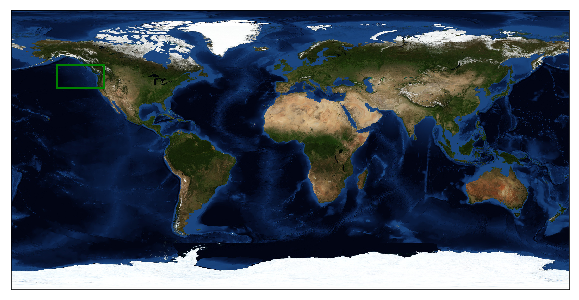

Time Series took 14.537447257000167 seconds to generate


In [3]:
import time
import nexuscli
from datetime import datetime

from shapely.geometry import box

# TODO: Create a bounding box using the box method imported above
bbox = box(-150, 40, -120, 55)

# TODO: Plot the bounding box using the helper method plot_box
plot_box(bbox)

start = time.perf_counter()

# TODO: Call the time_series method for the AVHRR_OI_L4_GHRSST_NCEI dataset using 
# your bounding box and time period 2013-01-01 through 2014-03-01
datasets = ["AVHRR_OI_L4_GHRSST_NCEI"]
start_time = datetime(2013, 1, 1)
end_time = datetime(2014, 3, 1)
ts = nexuscli.time_series(datasets, bbox, start_time, end_time, spark=True)

print("Time Series took {} seconds to generate".format(time.perf_counter() - start))


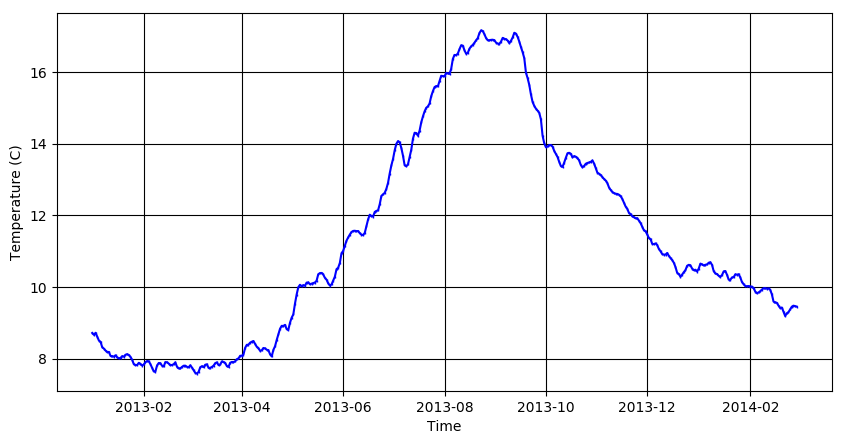

In [4]:
# TODO: Plot the result using the `show_plot` helper method
avhrr_ts = ts[0]
show_plot(avhrr_ts.time, avhrr_ts.mean, 'Time', 'Temperature (C)')

# Step 3a: Run for a Longer Time Period

Now that you have successfully generated a time series for approximately one year of data. Try generating a longer time series by increasing the end date to `2016-12-31`. This will take a little bit longer to execute, since there is more data to analyze, but should finish in under a minute.

The significant increase in sea surface temperature due to the blob should be visible as an upward trend between 2013 and 2015 in this longer time series.

## TODOs
1. Generate a longer time series from `2013-01-01` to `2016-12-31`
2. Plot the result using the `show_plot` helper method. Make sure you pass `spark=True` to the time_series function to speed up the analysis

## Advanced (Optional)
1. For an extra challenge, try plotting the trend line.
  - __Hint__ `numpy` and `scipy` packages are installed and can be used by importing them: `import numpy` or `import scipy`
  - __Hint__ You will need to convert the TimeSeries.time array to numbers in order to generate a polynomial fit line. `matplotlib` has a built in function capable of doing this: `matplotlib.dates.date2num` and it's inverse `matplotlib.dates.num2date`



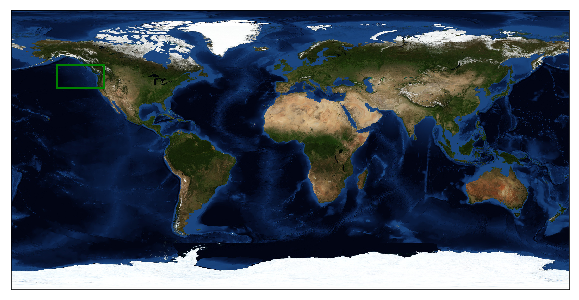

Time Series took 57.206473498023115 seconds to generate


In [5]:
import time
import nexuscli
from datetime import datetime

from shapely.geometry import box

bbox = box(-150, 40, -120, 55)
plot_box(bbox)

# Do not modify this line ##
start = time.perf_counter()#
############################

# TODO: Call the time_series method for the AVHRR_OI_L4_GHRSST_NCEI dataset using 
# your bounding box and time period 2013-01-01 through 2016-12-31
# Make sure you pass spark=True to the time_series function to speed up the analysis
datasets = ["AVHRR_OI_L4_GHRSST_NCEI"]
start_time = datetime(2013, 1, 1)
end_time = datetime(2016, 12, 31)
ts = nexuscli.time_series(datasets, bbox, start_time, end_time, spark=True)

# Enter your code above this line
print("Time Series took {} seconds to generate".format(time.perf_counter() - start))

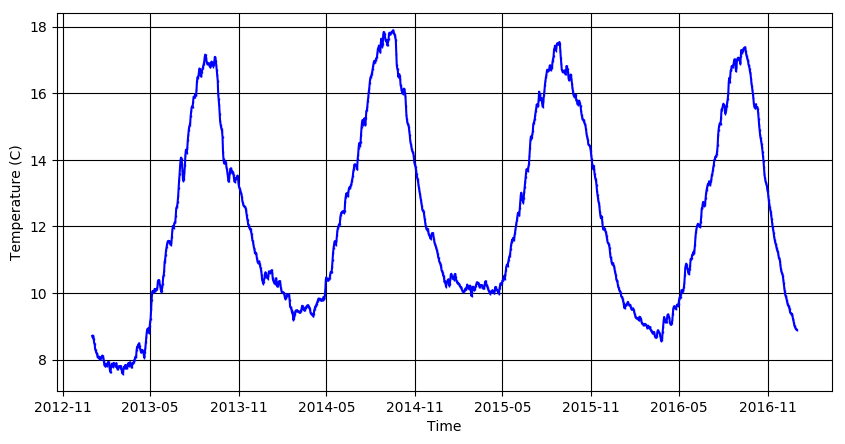

In [6]:
# TODO: Plot the result using the `show_plot` helper method
avhrr_ts = ts[0]
show_plot(avhrr_ts.time, avhrr_ts.mean, 'Time', 'Temperature (C)')

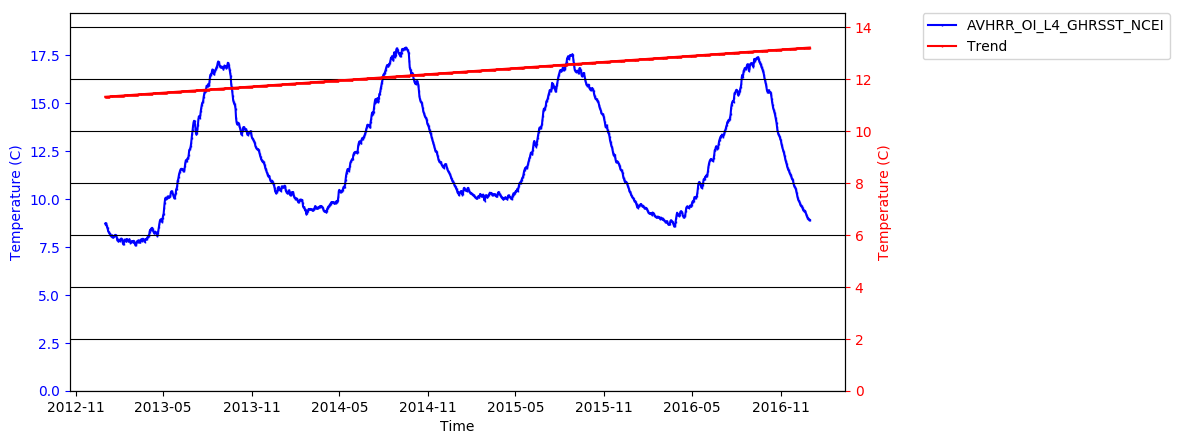

In [8]:
# Answer to Advanced challenge

import numpy as np
import matplotlib.dates as mdates

# Need to convert datetime objects to numbers to use numpy polyfit
time_nums = mdates.date2num(avhrr_ts.time)

# Generate a first degree polynomial best fit line
fit = np.polyfit(time_nums, avhrr_ts.mean, deg=1)
trend_poly = np.poly1d(fit)

# Convert numbers back to dates for plotting
trend_linspace = np.linspace(time_nums.min(), time_nums.max(), len(avhrr_ts.time))
trend_x_values = mdates.num2date(trend_linspace)

show_plot_two_series(
    avhrr_ts.time, trend_x_values, 
    avhrr_ts.mean, trend_poly(trend_linspace), 
    'Time', 'Temperature (C)', 'Temperature (C)',
    avhrr_ts.dataset, 'Trend'
)

# Step 4: Run two Time Series' and plot them side-by-side


The `time_series` method can be used on up to two datasets at one time for comparison. Let's take a look at another region and see how to generate two time series and plot them side by side.

> Hurricane Katrina passed to the southwest of Florida on Aug 27, 2005. The ocean response in a 1 x 1 degree region is captured by a number of satellites. The initial ocean response was an immediate cooling of the surface waters by 2 degrees Celcius that lingers for several days. The SST drop is correlated to both wind and precipitation
data.

> _A study of a Hurricane Katrina–induced phytoplankton bloom using satellite observations and model simulations
Xiaoming Liu, Menghua Wang, and Wei Shi1
JOURNAL OF GEOPHYSICAL RESEARCH, VOL. 114, C03023, doi:10.1029/2008JC004934, 2009
http://shoni2.princeton.edu/ftp/lyo/journals/Ocean/phybiogeochem/Liu-etal-KatrinaChlBloom-JGR2009.pdf _

Plot the time series for the `AVHRR_OI_L4_GHRSST_NCEI` SST dataset and the `TRMM_3B42_daily` Precipitation dataset for the region `-84.5, 23.5, -83.5, 24.5` and time frame of `2005-08-24` through `2005-09-10`. Plot the result using the `show_plot_two_series` helper method and see if you can recognize the correlation between the spike in precipitation and the decrease in temperature.

## TODOs
1. Create a bounding box for the region in the Gulf of Mexico that Hurricane Katrina passed through (`-84.5, 23.5, -83.5, 24.5`)
2. Plot the bounding box using the helper method plot_box
3. Generate the Time Series by calling the `time_series` method in the `nexuscli` module
4. Plot the result using the `show_plot_two_series` helper method

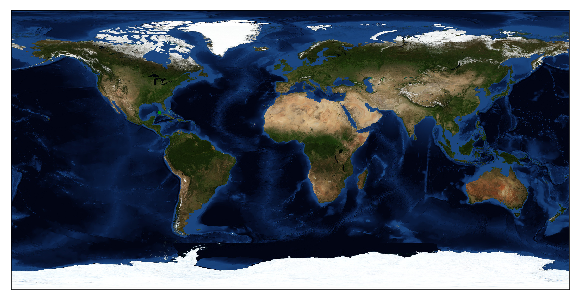

Time Series took 3.7812832609633915 seconds to generate


In [9]:
import time
import nexuscli
from datetime import datetime

from shapely.geometry import box

# TODO: Create a bounding box using the box method imported above
bbox = box(-84.5, 23.5, -83.5, 24.5)

# TODO: Plot the bounding box using the helper method plot_box
plot_box(bbox)

start = time.perf_counter()

# TODO: Call the time_series method for the AVHRR_OI_L4_GHRSST_NCEI dataset using 
# your bounding box and time period 2005-08-24 through 2005-09-10
datasets = ["AVHRR_OI_L4_GHRSST_NCEI", "TRMM_3B42_daily"]
start_time = datetime(2005, 8, 24)
end_time = datetime(2005, 9, 10)
ts2 = nexuscli.time_series(datasets, bbox, start_time, end_time)

print("Time Series took {} seconds to generate".format(time.perf_counter() - start))


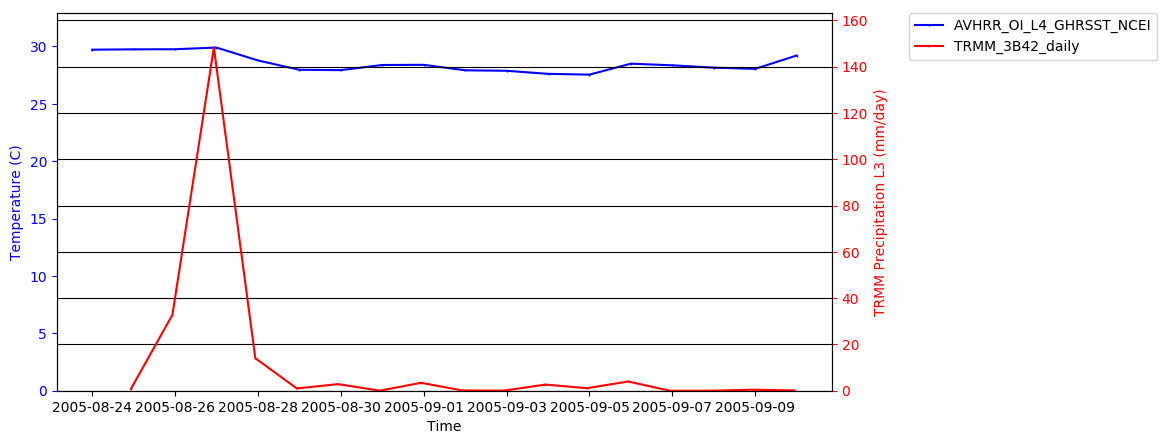

In [10]:
# TODO: Plot the result using the `show_plot_two_series` helper method
series_a, series_b = ts2
show_plot_two_series(
    series_a.time, series_b.time, 
    series_a.mean, series_b.mean, 
    'Time', 'Temperature (C)', 'TRMM Precipitation L3 (mm/day)',
    series_a.dataset, series_b.dataset
)

# Step 5: Run a Daily Difference Average (Anomaly) calculation

Let's return to The Blob region. But this time we're going to use a different calculation, Daily Difference Average (aka. Anomaly plot). 

The Daily Difference Average algorithm compares a dataset against a climatological mean and produces a time series of the difference from that mean. Given The Blob region, we should expect to see a positive difference from the mean temperature in that region (indicating higher temperatures than normal) between 2013 and 2014.

This time, using the `nexuscli` module, call the `daily_difference_average` method. The signature for that method is reprinted below:

>Generate an anomaly Time series for a given dataset, bounding box, and timeframe.  
>  
__dataset__ Name of the dataset as a String  
__bounding_box__ Bounding box for area of interest as a `shapely.geometry.polygon.Polygon`  
__start_datetime__ Start time as a `datetime.datetime`  
__end_datetime__ End time as a `datetime.datetime`  
>      
>__return__ List of `nexuscli.nexuscli.TimeSeries` namedtuples

Generate an anomaly time series using the `AVHRR_OI_L4_GHRSST_NCEI` SST dataset for the time period 2013-01-01 through 2016-12-31 and a bounding box `-150, 40, -120, 55` (west, south, east, north).

## TODOs

1. Generate the Anomaly Time Series by calling the `daily_difference_average` method in the `nexuscli` module
2. Plot the result using the `show_plot` helper method

## Advanced (Optional)

1. Generate an Anomaly Time Series for the [El Niño 3.4 region](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php) (bounding box -170, -5, -120, 5) from 2010 to 2015.

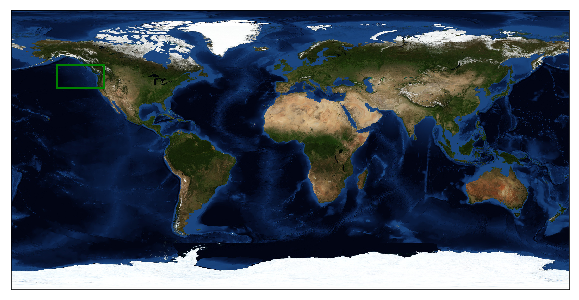

Daily Difference Average took 43.81050132296514 seconds to generate


In [11]:
import time
import nexuscli
from datetime import datetime

from shapely.geometry import box

bbox = box(-150, 40, -120, 55)
plot_box(bbox)

# Do not modify this line ##
start = time.perf_counter()#
############################

# TODO: Call the daily_difference_average method for the AVHRR_OI_L4_GHRSST_NCEI dataset using 
# your bounding box and time period 2013-01-01 through 2016-12-31. Be sure to pass spark=True as a parameter
# to speed up processing.
dataset = "AVHRR_OI_L4_GHRSST_NCEI"
start_time = datetime(2013, 1, 1)
end_time = datetime(2016, 12, 31)
dda = nexuscli.daily_difference_average(dataset, bbox, start_time, end_time)


# Enter your code above this line
print("Daily Difference Average took {} seconds to generate".format(time.perf_counter() - start))

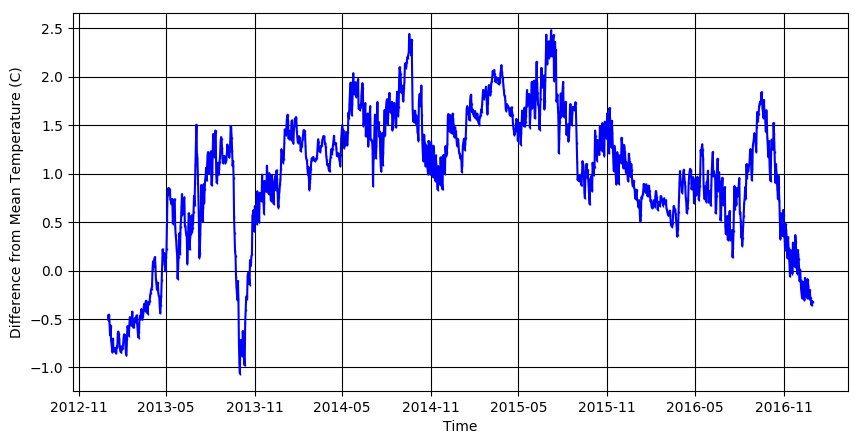

In [12]:
# TODO: Plot the result using the `show_plot` helper method
avhrr_dda = dda[0]
show_plot(avhrr_dda.time, avhrr_dda.mean, 'Time', 'Difference from Mean Temperature (C)')

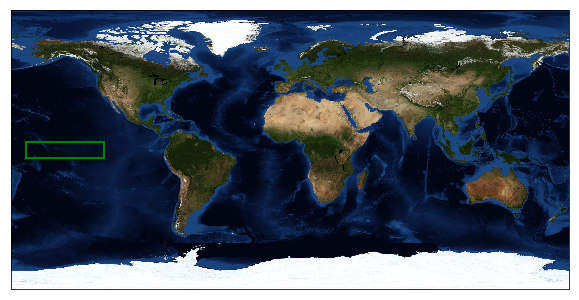

Daily Difference Average took 45.960542011016514 seconds to generate


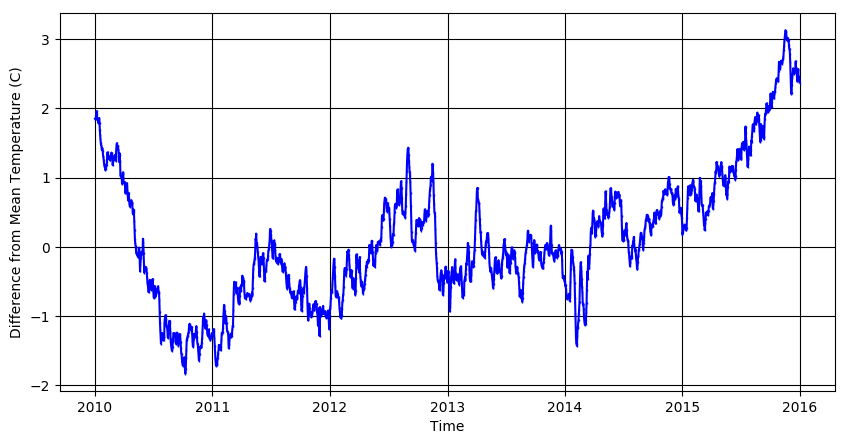

In [13]:
# Answer to Advanced challenge

import time
import nexuscli
from datetime import datetime

from shapely.geometry import box

bbox = box(-170, -5, -120, 5)
plot_box(bbox)

start = time.perf_counter()


dataset = "AVHRR_OI_L4_GHRSST_NCEI"
start_time = datetime(2010, 1, 1)
end_time = datetime(2015, 12, 31)
dda = nexuscli.daily_difference_average(dataset, bbox, start_time, end_time)

print("Daily Difference Average took {} seconds to generate".format(time.perf_counter() - start))

avhrr_dda = dda[0]
show_plot(avhrr_dda.time, avhrr_dda.mean, 'Time', 'Difference from Mean Temperature (C)')

# Congratulations!

You have finished this workbook.

If others are still working, please feel free to modify the examples and play with the client module or go back and complete the "Advanced" challenges if you skipped them. Further technical information about NEXUS can be found in the [GitHub repository](https://github.com/dataplumber/nexus).

If you would like to save this notebook for reference later, click on `File -> Download as...` and choose your preferred format.